<a href="https://colab.research.google.com/github/Fabchirajoul/Transformer_MLM_AND_BINARY_CLASSIFICATION/blob/main/MLM_WAYNE_HUGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install accelerate -U

In [2]:
# pip install transformers

In [3]:
# pip install datasets

In [35]:
from google.colab import files

# Upload an image file
uploaded_workflow = files.upload()

Saving workflow.JPG to workflow.JPG


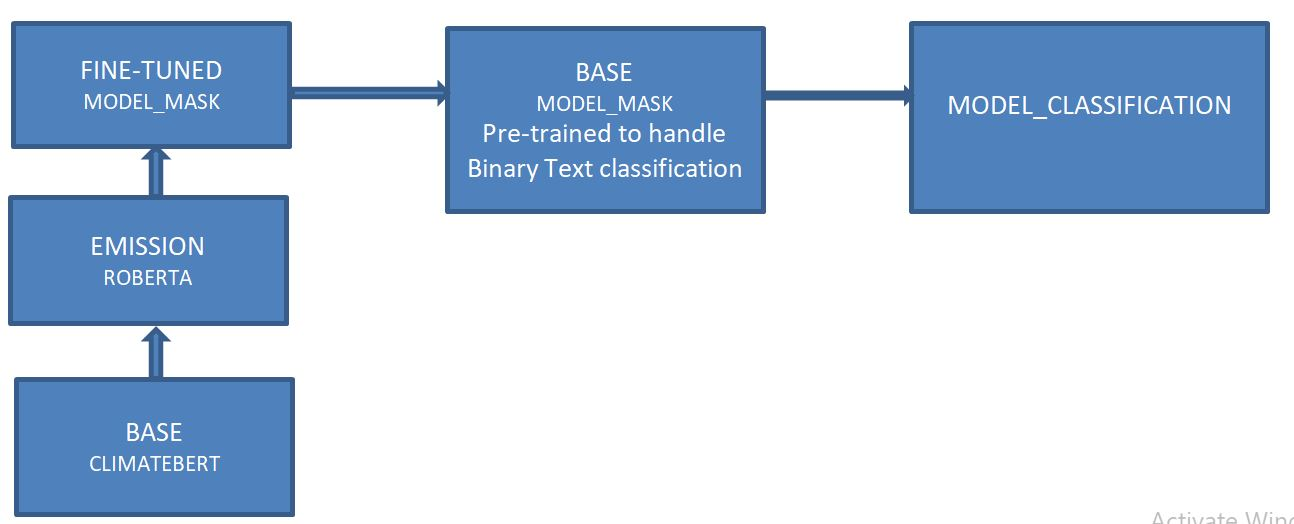

In [36]:
# Get the file name
workflow = list(uploaded_workflow.keys())[0]

# Display the uploaded image
from IPython.display import Image
Image(workflow)

# First we need to create a function that will randomly divide the single data file into training, testing and validation

In [4]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/testing_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/training_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/validation_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

## We now have our seperate datafiles for training, testing and validation

In [5]:
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import  pandas as pd
from transformers import DataCollatorWithPadding

import random
import torch
import math

data_files = {"train": "/content/training_dataset.csv",
              "validation": "/content/validation_dataset.csv",
              "test": "/content/testing_dataset.csv"
              }
df_Mask = load_dataset("csv", data_files=data_files)
df_Mask

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text'],
        num_rows: 756
    })
})

# Viewing the dictionary to see that they are actually what we want

In [6]:
print("================================================================================")
print("Training Data")
print(df_Mask['train'][0])
print("================================================================================")
print("Testing Data")
print(df_Mask['test'][0])
print("================================================================================")
print("Validation Data")
print(df_Mask['validation'][0])

Training Data
{'text': '. Eurazeo\'s long-lasting commitment to tackle climate issues has been strengthened in 2020 with the ambitious O+ engagement to become carbon net neutral by 2040 at the latest. Eurazeo aims to align its activities with a scenario limiting global warming to a well below 2°C threshold. This commitment led us to establish reduction targets which are calculated using a world-renowned scientific methodology: Science-Based Targets Initiative (SBTi). At management company level, the scope 1 and 2 objectives, validated per SBTi\'s scientific committee, are the following:• 2025: Eurazeo commits to increase annual sourcing of renewable electricity from 9% in 2017 to 80%• 2030: Eurazeo commits to reduce scope 1 and 2 GHG emissions by 80% per employee from a 2017 base year. Regarding scope 3 related emissions, a first target on business travels (from teams of Eurazeo Group) related emissions has been set during 2020. This is the target ABS2 presented here. However, our port

In [7]:
df_Mask_test = df_Mask["test"]
df_Mask_test[0]


{'text': 'Our emissions target is Net-Zero emissions by 2030. This means a target to reduce value chain emissions by an amount consistent with net-zero in global scenarios that limit warming to 1.5C with no or limited overshoot and a target to neutralize the impact of residual emissions (i.e. emissions that are unfeasible for society to abate in 1.5C.'}

In [8]:
df_Mask['train'].features

{'text': Value(dtype='string', id=None)}

In [9]:
df_Mask.keys()

dict_keys(['train', 'validation', 'test'])

TOKENIZATION

In [10]:
checkpoint = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



def tokenize_function(df_Mask):
    return tokenizer(df_Mask["text"], df_Mask['text'], df_Mask['text'], truncation=True, return_tensors='pt', padding="max_length")

tokenized_datasets = df_Mask.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 756
    })
})

In [11]:
tokenized_datasets['train'].features

{'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [12]:
tokenized_datasets.column_names

{'train': ['text', 'input_ids', 'attention_mask', 'labels'],
 'validation': ['text', 'input_ids', 'attention_mask', 'labels'],
 'test': ['text', 'input_ids', 'attention_mask', 'labels']}

# Removing columns which the machine will not understand

In [13]:
# Machine does not understand categorical data i.e. text so we need to remove it


columns_to_remove = ['text']

# Remove the specified columns from each split

for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].remove_columns(columns_to_remove)



tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Setting the dataframe to a pytoch dataframe

In [14]:
tokenized_datasets.set_format("torch")

In [15]:
tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Data Loader

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

# To quickly check there is no mistake in the data processing

In [17]:
# Assuming you have train_dataloader, eval_dataloader, and test_dataloader

dataloaders = {
    'Training': train_dataloader,
    'Evaluation': eval_dataloader,
    'Testing': test_dataloader
}

for split, dataloader in dataloaders.items():
    print(f"\nThe Shape of the  {split} dataloader:")
    for batch in dataloader:
        shapes = {k: v.shape for k, v in batch.items()}
        print(shapes)
        break

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



The Shape of the  Training dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}

The Shape of the  Evaluation dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}

The Shape of the  Testing dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}


# Passing the training batch to our model

In [18]:
# lastly calling the our pretrained model and passing the climatebert model to the pretrained model from hugging face
model_Mask = RobertaForMaskedLM.from_pretrained(checkpoint)

outputs = model_Mask(**batch)

print(outputs.loss, outputs.logits.shape)

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tensor(18.3644, grad_fn=<NllLossBackward0>) torch.Size([8, 512, 50500])


In [19]:
from transformers import AdamW

# Our Optimizer
optimizer = AdamW(model_Mask.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Learning Rate Scheduler

In [20]:
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

331


# Defining and Pushing the model to our Device

In [21]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_Mask.to(device)
print("========================================================================================")
print("Our available device which our model is going to be trained on is: \n\n", device)
print("========================================================================================")
# Making sure our model is ready to be  trained
print("Our Training Model architecture is: \n\n", model_Mask.train())
print("========================================================================================")

Our available device which our model is going to be trained on is: 

 cuda
Our Training Model architecture is: 

 RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSel

# Fine Tuning

In [22]:
from transformers import AdamW

# Our Optimizer
optimizer = AdamW(model_Mask.parameters(), lr=5e-5)





# Making Use of an Accelerator

In [23]:
from accelerate import Accelerator

accelerator = Accelerator()


train_dataloader, eval_dataloader, model_Mask, optimizer= accelerator.prepare(
    train_dataloader,
    eval_dataloader,
    model_Mask,
    optimizer
    )

# Training

In [24]:
from tqdm.auto import tqdm


# function to train the model
def train(
    model=model_Mask,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    # cross_entropy=cross_entropy,
    device=device,
    eval_dataset=eval_dataloader
):

  model_Mask.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        outputs = model_Mask(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/331 [00:00<?, ?it/s]

# Evaluaing

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set the model to evaluation mode
model_Mask.eval()

# Lists to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through the evaluation dataloader
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_Mask(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    labels = batch["labels"].cpu().numpy()

    all_predictions.extend(predictions.flatten())
    all_labels.extend(labels.flatten())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calculate precision, recall, F1 score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(
    all_labels, all_predictions, average="weighted", zero_division=1
)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"Support: {support}")


Accuracy: 0.957
Precision: 0.958
Recall: 0.957
F1 Score: 0.953
Support: None


In [26]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_predictions)

# # Visualize the confusion matrix using seaborn heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


# Saving the model

In [39]:
torch.save(model_Mask.state_dict(), 'model_mask_learning_model.pt')

# THIS SECTION REQUIRES THE USE OF THE MODEL_MASK FOR A BINARY TEXT CLASSIFICATION TASK ON A DIFFERENT DATASET

# SPLITTING OUR CUSTOM DATASET INTO TRAINING, TESTING AND VALIDATION

In [27]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/testing_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/training_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/validation_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

# LOADING AND COMBINING OUR DATASET AS A DICTIONAARY

In [28]:
data_files = {"train": "/content/training_dataset_classification.csv",
              "validation": "/content/validation_dataset_classification.csv",
              "test": "/content/testing_dataset_classification.csv"
              }
df_classification = load_dataset("csv", data_files=data_files)
df_classification

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 79
    })
})

# LET US VIEW WHAT WE HAVE SPLITTED

In [29]:
print("================================================================================")
print("Training Data for classification")
print(df_classification['train'][1])
print("================================================================================")
print("Testing Data for classification")
print(df_classification['test'][2])
print("================================================================================")
print("Validation Data for classification")
print(df_classification['validation'][3])

Training Data for classification
{'text': 'This provided management with a basis for setting new energy-use tar- gets and defining operational and stra- tegic energy objectives”, explains Nicole von der Weiden, who is responsible for energy management at Brezelkönig/ Ditsch.', 'label': 0}
Testing Data for classification
{'text': 'Virtual power plants represent a major opportunity for EnBW to transfer its knowledge on the safe operation of complex systems to new digital business models.', 'label': 0}
Validation Data for classification
{'text': 'The essence of digital farming consists in aggregating and creating value from data, which is no longer sourced merely from farm equipment but is also generated using new services and algorithms and transformed into actionable intelligence.', 'label': 0}


# Checking the data type so we know what to encode

In [30]:
print("======================================================================================")
print("The features i.e. the data types for our dataset dictionary are: \n\n", df_classification["train"].features)
print("======================================================================================")
print("Our dataset dictionary contains the following: \n\n", df_classification.keys())
print("======================================================================================")


# Based on the output, we see that we only need to tokenize the test data since they are categorical and the machine cannot understand categorical variables.

The features i.e. the data types for our dataset dictionary are: 

 {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}
Our dataset dictionary contains the following: 

 dict_keys(['train', 'validation', 'test'])


# TOKENIZATION